Participants that were told: 1
Participants that were not told: 0


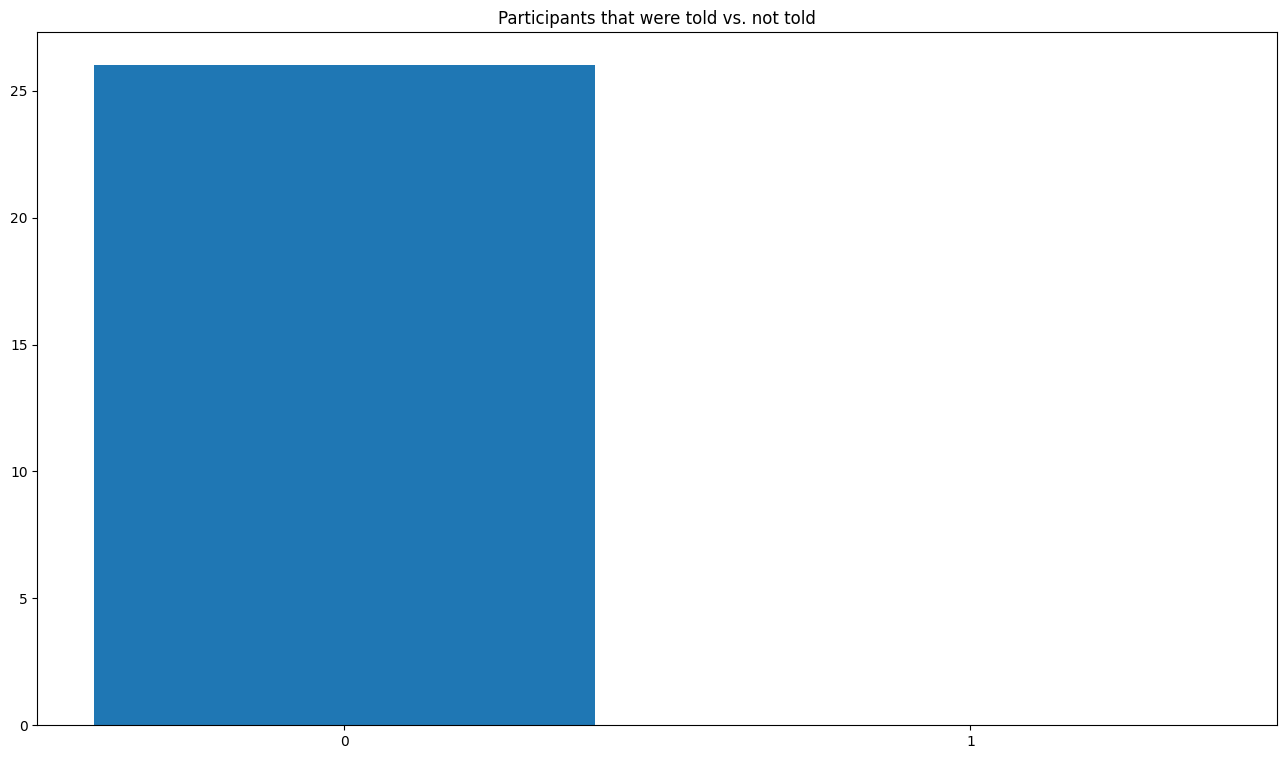

In [10]:
from utils import Events
import matplotlib.pyplot as plt
from peewee import fn

INFORMED_TREATMENTS = ["Treatment 2,1", "Treatment 2,2", "Treatment 2,3"]
UNINFORMED_TREATMENTS = ["Treatment 2,4", "Treatment 2,5", "Treatment 2,6"]

PARTICIPANTS_THAT_WERE_NOT_TOLD = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(UNINFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
)


PARTICIPANTS_THAT_WERE_TOLD = (
    Events.select(
        Events.participant_id,
        fn.COUNT().alias("event_count"),
    )
    .where(
        (Events.event.startswith("SET_"))
        & Events.participant_id.in_(
            Events.select(Events.participant_id).where(
                (Events.new_value.in_(INFORMED_TREATMENTS))
            )
        )
    )
    .group_by(Events.participant_id)
).execute()

informed_amount_of_adjustments = sum(
    [p.event_count for p in PARTICIPANTS_THAT_WERE_TOLD]
)
uninformed_amount_of_adjustments = sum(
    [p.event_count for p in PARTICIPANTS_THAT_WERE_NOT_TOLD]
)


fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Participants that were told vs. not told")
plt.bar(label="Told", x=0, height=informed_amount_of_adjustments)
plt.bar(label="Not told", x=1, height=uninformed_amount_of_adjustments)

# Remove xticks
ax.set_xticks([0, 1])

In [ ]:
for participant in PARTICIPANTS_THAT_WERE_TOLD:
    # get all of this participant's events
    all_events = Events.select().where(Events.participant_id == participant).order_by(Events.time.asc())

    # get the first OPEN_BOOK event for this participant  
    open_book_event = all_events.where(Events.event == 'OPEN_BOOK').order_by(Events.time.asc()).limit(1)[0]

    # get the first CLOSE_BOOK event for this participant
    close_book_event = all_events.where(Events.event == 'CLOSE_BOOK').order_by(Events.time.asc()).limit(1)[0]

    events_for_book1 = all_events.where(Events.participant_id == participant).where(Events.time.between(open_book_event.time, close_book_event.time)).order_by(Events.time.asc())

    number_changes_book1 = len([event for event in events_for_book1 if event.event.startswith('SET_')])